In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

Assumptions and methods:

1. No memory / CPU exhaustive applications were
running 
2. Limited measurement to 8 MB L3 cache (AWS has Xeon processor with 30
MB L3 cache)
3. We set CPU affinity so the program runs in one CPU only

# Cache Size

> Measuring the size of the cache is achieved by increasing the
value of N until cache misses start to
occur. When this happens the time per
iteration becomes significantly larger than Tno −miss . The cache
size is given
by the largest N such that the average time iteration is equal to Tno −miss .

## Explanation

We access the array by jumping from one element into another with predefined variable (stride). We access the array by `2**x` pages where x is {1, 2, 3, ..., 12}. Each page we repeat the iteration as many as possible (not too long not too short, kind of state of art), to avoid our measurement being overshadowed by the noise from other function call. We then find the average.

**Machine 1:**
L1 cache: 8 pages (~32 Kb)
L2 cache: 64 pages (~256 Kb)
L3 cache:
2048 pages (~8 Mb)

**Machine 2:**
L1 cache: 8 pages (~32 Kb)
L2 cache: 64 pages (~256 Kb)
L3 cache:
2048 pages (~8 Mb)


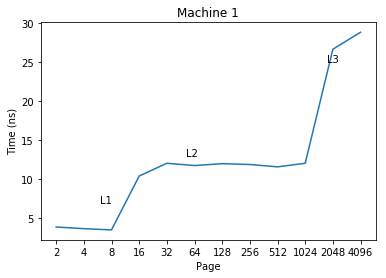

In [49]:
cache_size = pd.read_csv("cache_size.csv")

plt.title("Machine 1")
plt.plot(cache_size.index, cache_size.cpu_time)
plt.xticks(cache_size.index, cache_size.page)
plt.xlabel('Page')
plt.ylabel('Time (ns)')
plt.annotate('L1', xy=(1.6, 7))
plt.annotate('L2', xy=(4.7, 13))
plt.annotate('L3', xy=(9.8, 25))
plt.show()

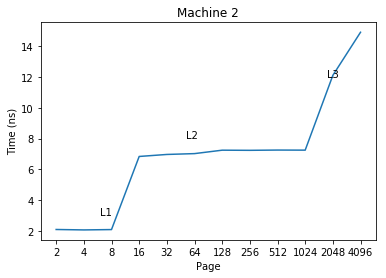

In [51]:
cache_size = pd.read_csv("cache_size_mac.csv")

plt.title("Machine 2")
plt.plot(cache_size.index, cache_size.cpu_time)
plt.xticks(cache_size.index, cache_size.page)
plt.xlabel('Page')
plt.ylabel('Time (ns)')
plt.annotate('L1', xy=(1.6, 3))
plt.annotate('L2', xy=(4.7, 8))
plt.annotate('L3', xy=(9.8, 12))
plt.show()



# Cache Line Size

> In regime 2.a, the rate at which misses occur is one every
b /s iterations. This rate increases with s,
and achieves its maximum when s ≥ b
, when there is a miss on every iteration (regime 2.b). The value of
s when the
transition between regimes 2.a and 2.b happens gives the cache line size.
Predicted cache line size: 64 bytes

## Explanation

Cache line is the number of
memory that is transferred from memory to CPU to create the cache entry. Let's
focus on the specific part of the graph. X axis is the element index of the
array and Y axis is the time needed to access that element in nano second. If we
see the element 1024, we see a spike and the goes down at 1025 and then stays
the same until 1039, before rises again at 1040. Therefore, the predicted line
size in this case is 1040 - 1024 = 16. Since one integer is 4 bytes then 16 x 4
bytes = 64 bytes.

Source: http://www.aristeia.com/TalkNotes/ACCU2011_CPUCaches.pdf

In [13]:
line_data = pd.read_csv("line_size.csv")

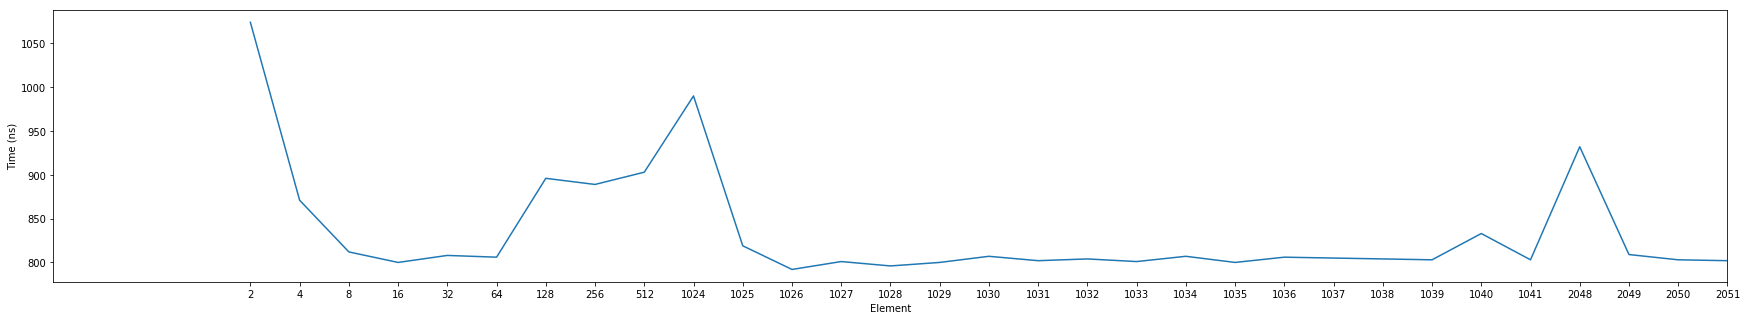

In [15]:
plt.figure(figsize=(30, 5))
plt.plot(line_data.index, line_data.time)
plt.xticks(line_data.index, line_data.element)
plt.xlim(xmax=30)
plt.xlabel('Element')
plt.ylabel('Time (ns)')
plt.show()

# Associativity

## Explanation

Measuring associativity is hard in this case. My approach is to access the first 8192 element of integer (32 kb), and see where it takes longer, if it takes longer at every x iteration, then x is the way of associativity.

However, the result I get by using this approach shows nothing:

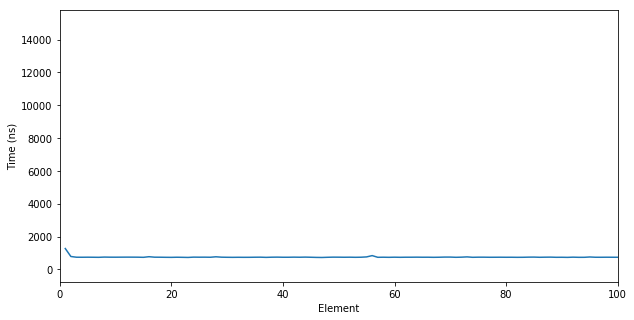

In [27]:
assc = pd.read_csv("associativity.csv")
assc = assc[0:8193:]
plt.figure(figsize=(10, 5))
plt.xlim(xmax=100)
plt.plot(assc["element"], assc["time"])
plt.xlabel('Element')
plt.ylabel('Time (ns)')
plt.show()

There are some possible explanations:

1. Our code gets optimised by the compiler
2. There may have been times when a disk interrupt or other event cause the operating system to interrupt the program.

To avoid that problem I tried to repeat the experiment thousand of times and measure the time.

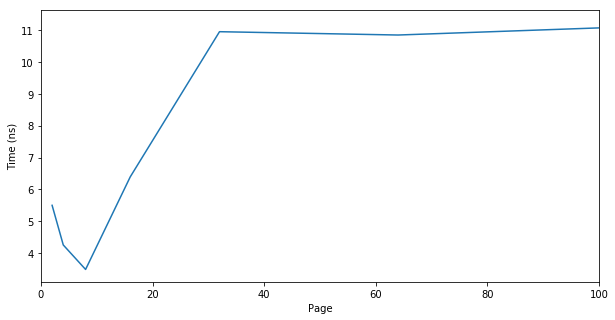

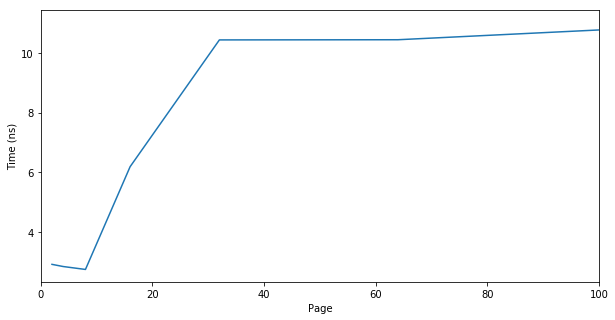

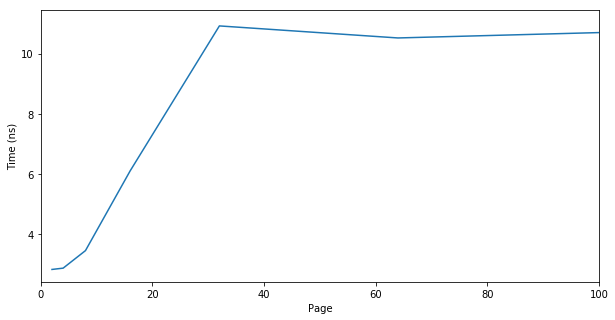

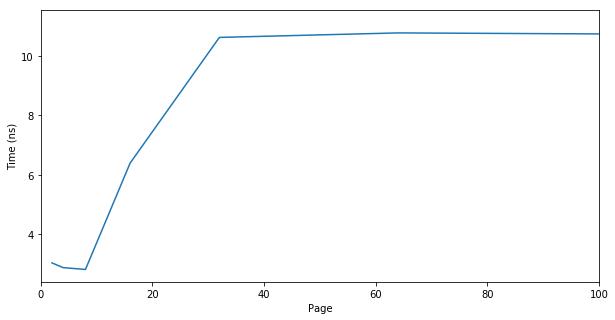

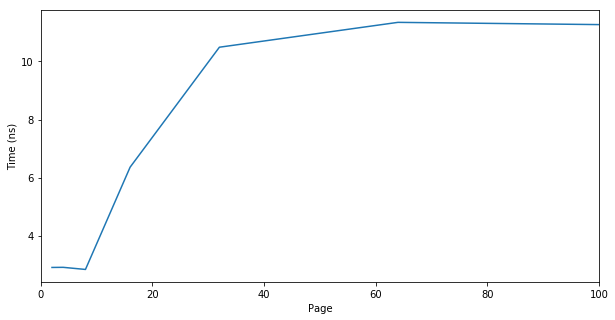

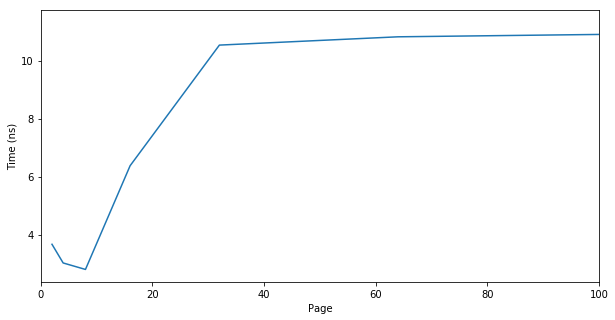

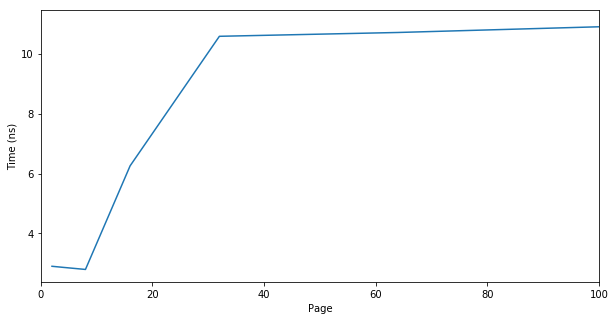

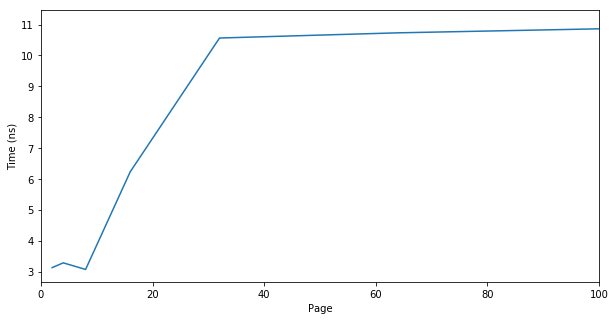

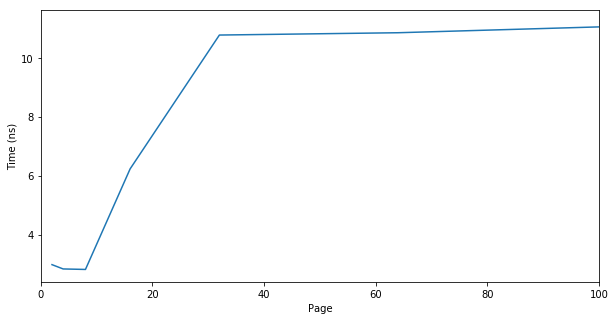

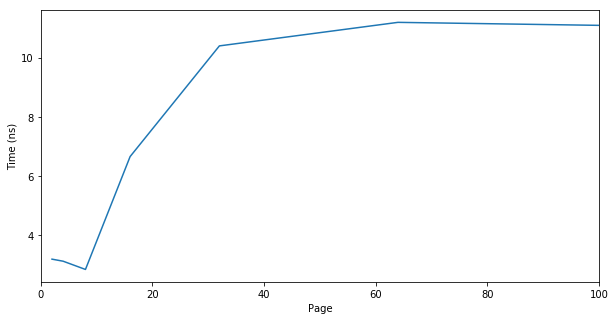

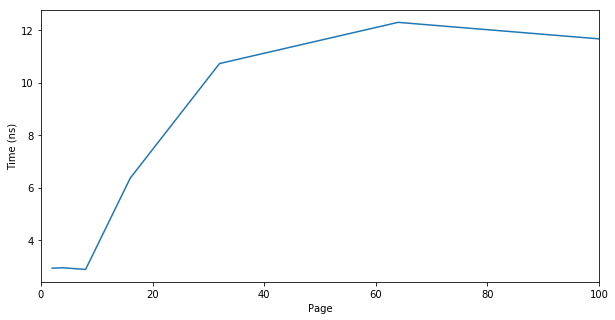

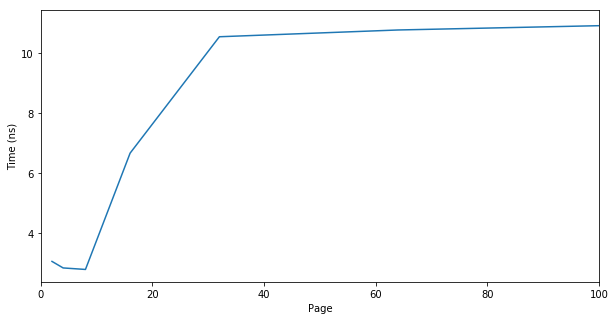

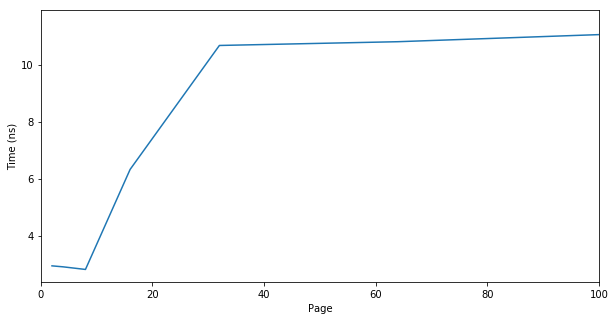

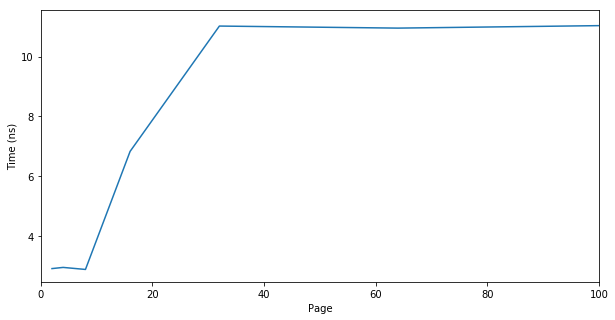

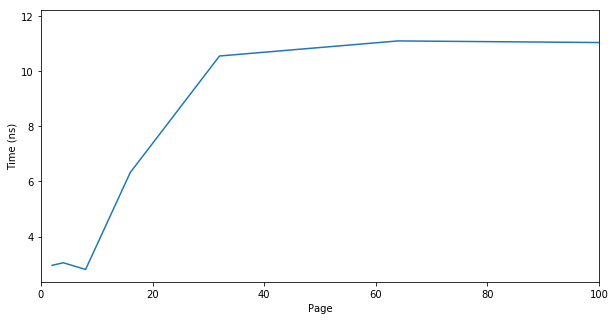

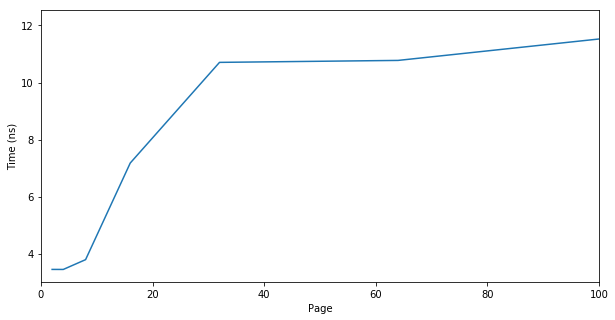

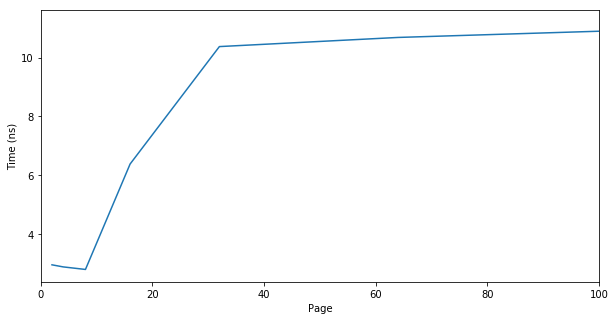

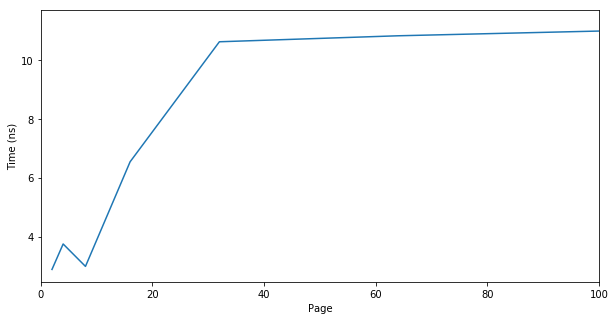

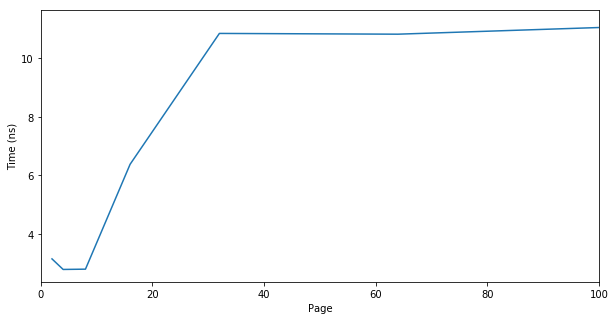

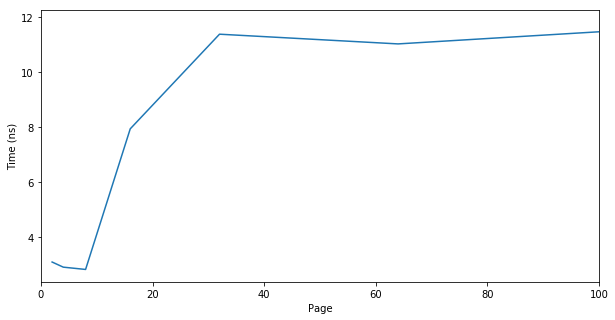

In [47]:
assc_1 = pd.read_csv("associativity_1.csv")

j = 0
for i in range(0, int(len(assc_1) / 8)):
    temp = assc_1[j:j+8]
    plt.figure(figsize=(10, 5))
    plt.xlim(xmax=100)
    plt.plot(temp["element"], temp["time"])
    plt.xlabel('Page')
    plt.ylabel('Time (ns)')
    plt.show()
    j += 8
    


After running 20 times, I still cannot see the difference thus I cannot inference the associativity from the graphs.